In [10]:
import os

import matplotlib as mpl
import matplotlib.pyplot as plt
from IPython.display import display
%matplotlib inline
import cv2
import pandas as pd
import numpy as np
!pip install mahotas
import mahotas as mt
import imutils
from PIL import Image
import glob
from skimage.feature import hog
from skimage.color import rgb2grey

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from skimage.feature import local_binary_pattern, greycomatrix, greycoprops
from sklearn.metrics import roc_curve, auc
import pickle

In [11]:
train_path = "/content/sample_data/dataset"
train_names = os.listdir(train_path)
print(train_names)

# empty list to hold feature vectors and train labels
train_features1 = []
train_labels1 = []

['no', 'yes', '.ipynb_checkpoints']


In [12]:
def extract_features(image):
        # calculate haralick texture features for 4 types of adjacency
        textures = mt.features.haralick(image)

        # take the mean of it and return it
        ht_mean = textures.mean(axis=0)
        return ht_mean

In [13]:
def sobel(img):    
    sobelx=cv2.Sobel(img,cv2.CV_64F,1,0)
    sobely=cv2.Sobel(img,cv2.CV_64F,0,1)
    sobelx=np.uint8(np.absolute(sobelx))
    sobely=np.uint8(np.absolute(sobely))
    combined=cv2.bitwise_or(sobelx,sobely)
    #randomstate=8
    return combined


In [14]:

for train_name in train_names:
        cur_path = train_path + "/" + train_name
        cur_label = train_name
        i = 1
        for file in glob.glob(cur_path + "/*"):
                print("Processing Image - {} in {}".format(i, cur_label))
                # read the training image
                img = cv2.imread(file)
                print(cur_path)
                img1 = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
                img1= cv2.medianBlur(img1, 3)
                img1=sobel(img1)
                gCoMat = greycomatrix(img1, [2], [0],256,symmetric=True, normed=True) 
                contrast = greycoprops(gCoMat, prop='contrast')
                dissimilarity = greycoprops(gCoMat, prop='dissimilarity')
                homogeneity = greycoprops(gCoMat, prop='homogeneity')
                energy = greycoprops(gCoMat, prop='energy')
                correlation = greycoprops(gCoMat, prop='correlation')
                contrast = contrast[0].reshape(-1)
                dissimilarity = dissimilarity[0].reshape(-1)
                homogeneity = homogeneity[0].reshape(-1)
                energy = energy[0].reshape(-1)
                correlation = correlation[0].reshape(-1)
                vector=np.hstack([contrast,dissimilarity,homogeneity,energy, correlation])
                #vector=extract_features(img1)
                train_features1.append(vector)
                train_labels1.append(cur_label)
                i+=1

Processing Image - 1 in no
/content/sample_data/dataset/no
Processing Image - 2 in no
/content/sample_data/dataset/no
Processing Image - 3 in no
/content/sample_data/dataset/no
Processing Image - 4 in no
/content/sample_data/dataset/no
Processing Image - 5 in no
/content/sample_data/dataset/no
Processing Image - 6 in no
/content/sample_data/dataset/no
Processing Image - 7 in no
/content/sample_data/dataset/no
Processing Image - 8 in no
/content/sample_data/dataset/no
Processing Image - 9 in no
/content/sample_data/dataset/no
Processing Image - 10 in no
/content/sample_data/dataset/no
Processing Image - 11 in no
/content/sample_data/dataset/no
Processing Image - 12 in no
/content/sample_data/dataset/no
Processing Image - 13 in no
/content/sample_data/dataset/no
Processing Image - 14 in no
/content/sample_data/dataset/no
Processing Image - 15 in no
/content/sample_data/dataset/no
Processing Image - 16 in no
/content/sample_data/dataset/no
Processing Image - 17 in no
/content/sample_data/

In [15]:
print("Training features: {}".format(np.array(train_features1).shape))
print("Training labels: {}".format(np.array(train_labels1).shape))

Training features: (400, 5)
Training labels: (400,)


In [16]:
from sklearn.svm import LinearSVC
print("[STATUS] Creating the classifier..")
clf_svm = LinearSVC(random_state=8)

# fit the training data and labels
print("[STATUS] Fitting data/label to model..")
clf_svm.fit(train_features1, train_labels1)

[STATUS] Creating the classifier..
[STATUS] Fitting data/label to model..


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=8, tol=0.0001,
          verbose=0)

In [17]:
data = np.array(train_features1)
data.shape
data.reshape(-1,1)
data.shape

(400, 5)

In [18]:
ss = StandardScaler()
# run this on our feature matrix
stand = ss.fit_transform(data)

pca = PCA(n_components=500)
# use fit_transform to run PCA on our standardized matrix
sort_pca = ss.fit_transform(stand)
# look at new shape
print('PCA matrix shape is: ', sort_pca.shape)
X = pd.DataFrame(sort_pca)

y = pd.Series(train_labels1)


PCA matrix shape is:  (400, 5)


In [19]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=8)
                                                    
# look at the distrubution of labels in the train set
pd.Series(y_train).value_counts()
from sklearn.svm import SVC
clf_svc = SVC(kernel='linear',random_state=8, probability=True)
clf_svc.fit(X_train,y_train)
print(clf_svc.score(X_test,y_test))
y_pred = clf_svc.predict(X_test)

0.875


In [20]:
from sklearn.metrics import classification_report, confusion_matrix
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))

[[38  8]
 [ 2 32]]
              precision    recall  f1-score   support

          no       0.95      0.83      0.88        46
         yes       0.80      0.94      0.86        34

    accuracy                           0.88        80
   macro avg       0.88      0.88      0.87        80
weighted avg       0.89      0.88      0.88        80



In [21]:
import pandas as pd
from sklearn.tree import DecisionTreeClassifier # Import Decision Tree Classifier
from sklearn.model_selection import train_test_split # Import train_test_split function
from sklearn import metrics #Import scikit-learn metrics module for accuracy calculation
clf = DecisionTreeClassifier()

# Train Decision Tree Classifer
clf = clf.fit(X_train,y_train)
#Predict the response for test dataset
y_pred = clf.predict(X_test)
# calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print('Model accuracy is: ', accuracy)

Model accuracy is:  0.8375


In [22]:
from sklearn.ensemble import RandomForestClassifier
clf_rf = RandomForestClassifier(n_estimators=100, random_state=8)
clf_rf.fit(X_train,y_train)
print(clf_rf.score(X_test,y_test))

0.875


In [23]:
pkl_filename = "/content/pickle_model.pkl"
with open(pkl_filename, 'wb') as file:
    pickle.dump(clf, file)

# Load from file
with open(pkl_filename, 'rb') as file:
    pickle_model = pickle.load(file)
    
# Calculate the accuracy score and predict target values
score = pickle_model.score(X_test, y_test)
print("Test score: {0:.2f} %".format(100 * score))
Ypredict = pickle_model.predict(X_test)
print(Ypredict)
print(X_test)


Test score: 83.75 %
['no' 'yes' 'no' 'yes' 'no' 'yes' 'yes' 'no' 'no' 'no' 'no' 'yes' 'no'
 'yes' 'yes' 'yes' 'yes' 'no' 'no' 'no' 'no' 'no' 'no' 'yes' 'yes' 'no'
 'yes' 'yes' 'no' 'no' 'yes' 'yes' 'no' 'no' 'yes' 'no' 'yes' 'no' 'no'
 'no' 'yes' 'no' 'no' 'no' 'yes' 'no' 'yes' 'yes' 'yes' 'no' 'no' 'yes'
 'no' 'no' 'no' 'no' 'no' 'no' 'no' 'no' 'no' 'no' 'yes' 'yes' 'no' 'no'
 'yes' 'yes' 'yes' 'no' 'yes' 'no' 'yes' 'yes' 'no' 'yes' 'yes' 'yes' 'no'
 'yes']
            0         1         2         3         4
68  -0.875755 -0.806193 -1.274361 -1.428086  1.591187
222  0.093232  0.391771  0.048598  0.049609 -0.897925
53  -0.889568 -0.936064  0.504597  0.382015 -0.349399
305  0.362271  0.785874 -0.589617 -0.349776 -0.804149
0   -0.266160 -0.488936 -0.593365 -1.113082  0.637833
..        ...       ...       ...       ...       ...
247  0.916923  0.667084 -0.624294 -0.580705 -0.964170
237  0.780364  0.630198  0.710802  0.911705 -0.027664
333  0.703529  0.568615  0.109521  0.253496 -0.0086

Original Dimensions :  (266, 190, 3)


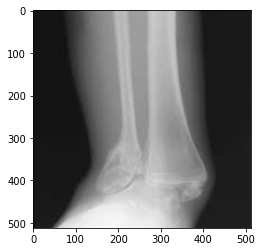

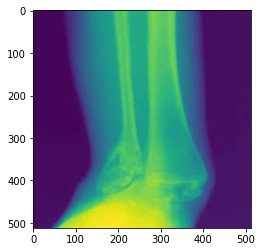

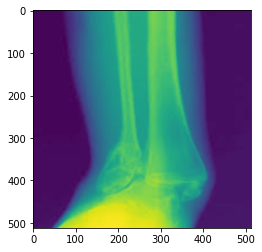

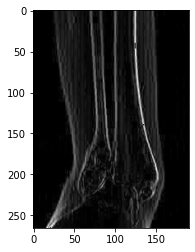

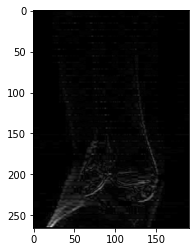

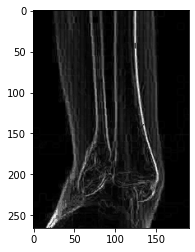

it is hand


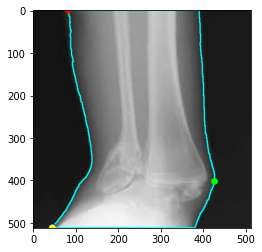

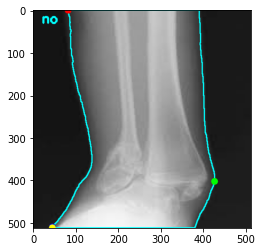

In [24]:
import math
import cv2
import imutils
# load the image, convert it to grayscale, and blur it slightly
img = cv2.imread("/content/sample_data/dataset/no/182.jpg")
print('Original Dimensions : ', img.shape)

width = 512
height = 512
dim = (width, height)

# resize image
resized = cv2.resize(img, dim, interpolation=cv2.INTER_AREA)
plt.imshow(resized)
plt.show()
gray = cv2.cvtColor(resized, cv2.COLOR_BGR2GRAY)
gray = cv2.GaussianBlur(gray, (5, 5), 0)
plt.imshow(gray)
plt.show()
median_blur = cv2.medianBlur(gray, 3)
plt.imshow(median_blur)
plt.show()
# threshold the image, then perform a series of erosions +
# dilations to remove any small regions of noise
img1 = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
img1= cv2.medianBlur(img1, 3)
sobelx=cv2.Sobel(img,cv2.CV_64F,1,0)
sobely=cv2.Sobel(img,cv2.CV_64F,0,1)
sobelx=np.uint8(np.absolute(sobelx))
plt.imshow(sobelx)
plt.show()
sobely=np.uint8(np.absolute(sobely))
plt.imshow(sobely)
plt.show()
combined=cv2.bitwise_or(sobelx,sobely)
plt.imshow(combined)
plt.show()
img1 = cv2.cvtColor(combined,cv2.COLOR_RGB2GRAY)
gCoMat = greycomatrix(img1, [2], [0],256,symmetric=True, normed=True) 
contrast = greycoprops(gCoMat, prop='contrast')
dissimilarity = greycoprops(gCoMat, prop='dissimilarity')
homogeneity = greycoprops(gCoMat, prop='homogeneity')
energy = greycoprops(gCoMat, prop='energy')
correlation = greycoprops(gCoMat, prop='correlation')
contrast = contrast[0].reshape(-1)
dissimilarity = dissimilarity[0].reshape(-1)
homogeneity = homogeneity[0].reshape(-1)
energy = energy[0].reshape(-1)
correlation = correlation[0].reshape(-1)
vector=np.hstack([contrast,dissimilarity,homogeneity,energy, correlation])
thresh = cv2.threshold(median_blur, 45, 255, cv2.THRESH_BINARY)[1]
thresh = cv2.erode(thresh, None, iterations=2)
thresh = cv2.dilate(thresh, None, iterations=2)
# find contours in thresholded image, then grab the largest
# one
cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL,
                        cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)
c = max(cnts, key=cv2.contourArea)
# determine the most extreme points along the contour
extLeft = c[c[:, :, 0].argmin()][0]
extRight = c[c[:, :, 0].argmax()][0]
extTop = c[c[:, :, 1].argmin()][0]
extBot = c[c[:, :, 1].argmax()][0]

# draw the outline of the object, then draw each of the
# extreme points, where the left-most is red, right-most
# is green, top-most is blue, and bottom-most is teal
cv2.drawContours(resized, [c], -1, (0, 255, 255), 2)
cv2.circle(resized, tuple(extLeft), 8, (0, 0, 255), -1)
cv2.circle(resized, tuple(extRight), 8, (0, 255, 0), -1)
cv2.circle(resized, tuple(extTop), 8, (255, 0, 0), -1)
cv2.circle(resized, tuple(extBot), 8, (255, 255, 0), -1)
# def calculate_angle(extLeft, extTop):
dot = np.dot(extLeft, extTop)
x_modulus = np.sqrt((extLeft * extLeft).sum())
y_modulus = np.sqrt((extTop * extTop).sum())
cos_angle = dot / x_modulus / y_modulus
angle = np.degrees(np.arccos(cos_angle))
if angle > 70:
    print("it is hand")
else:
    if angle < 70:
        print("the image is leg")

# show the output image
plt.imshow(resized)
plt.show()
prediction = clf_svm.predict(vector.reshape(1, -1))[0]
cv2.putText(resized, prediction, (20,30), cv2.FONT_HERSHEY_SIMPLEX, 1.0, (0,255,255), 3)

plt.imshow(resized)
plt.show()